In [22]:
import sys
import re
sys.path.append('../')
import time
import collections
import argparse
import os
import shutil
import json
import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import SGD
from torchvision import models, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable

import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import numpy as np

from sklearn.metrics import jaccard_similarity_score
import warnings
warnings.filterwarnings('ignore')

## Possible Improvements

- Figure out transform for inception net
    * 
- Examine Loss function
- Visualize attention maps from different layers

In [23]:
%load_ext autoreload
%autoreload 2
# from my_optim import get_optimizer, adject_lr
import exper.my_optim as my_optim
from models import *
from utils import AverageMeter
from utils import Metrics
from utils.save_atten import SAVE_ATTEN
#from utils.LoadData import data_loader2, data_loader
from utils.LoadDataKitti import data_loader
from utils.Restore import restore

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
class dummy_val_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 2
        self.lr = 0.001
        self.num_classes = 2
        self.num_gpu = 1
        self.threshold = 0.6
        self.snapshot_dir = "../snapshots/inception_kitti_full_spg_exp2/"
        self.restore_from = "kitti_epoch_8_glo_step_3987.pth.tar"
        self.resume = "True"
        self.tencrop = "False"

class dummy_tr_args:
    def __init__(self):
        self.arch = "inception3_spg"
        self.batch_size = 8
        self.lr = 0.001
        self.epoch = 25
        self.num_gpu = 1
        self.num_classes = 2
        self.snapshot_dir = "../snapshots/pretrain_imagenet/"
        self.restore_from = "imagenet_epoch_2_glo_step_128118.pth.tar"
        self.global_counter = 0
        self.current_epoch = 0
        self.threshold = 0.6
        self.decay_points = "none"
        self.onehot = 'False'
        self.disp_interval = 100
        self.dataset = "kitti"
        self.resume = "True"

        

val_args = dummy_val_args()
args = dummy_tr_args()
        

In [25]:
def get_model(args):
    model = eval(args.arch).model(pretrained=False,
                                  num_classes=1000,
                                  threshold=args.threshold,
                                  args=args)
    model.cuda()
    model = torch.nn.DataParallel(model, range(args.num_gpu))

    optimizer = my_optim.get_finetune_optimizer(args, model)

    if args.resume == 'True':
        restore(args, model, optimizer, including_opt=False)
    return  model, optimizer

def save_checkpoint(args, state, is_best, filename='checkpoint.pth.tar'):
    savepath = os.path.join(args.snapshot_dir, filename)
    torch.save(state, savepath)
    if is_best:
        shutil.copyfile(savepath, os.path.join(args.snapshot_dir, 'model_best.pth.tar'))

In [6]:
def evaluate(args, model, loader):
    losses = AverageMeter()
    top1 = AverageMeter()
    losses.reset()
    top1.reset()

    model.eval()
    for idx, dat in enumerate(loader):
        img, label = dat
        if len(img) == 1:
            continue
        label = torch.FloatTensor([t["label"] for t in label])[:, None]

        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])
        
        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
#         if args.tencrop == 'True':
#             logits0 = logits0.view(bs, ncrops, -1).mean(1)

        # Calculate classification results
#         if args.onehot == 'True':
#             val_mAP, prob, gt = cal_mAP(logits0, label_var, prob, gt)
            # print val_mAP
#         else:
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

    return losses.avg, top1.avg

In [ ]:

def train(args):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    model, optimizer= get_model(args)
    model.train()
    train_loader, val_loader = data_loader(args)

    with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
        config = json.dumps(vars(args), indent=4, separators=(',', ':'))
        fw.write(config)
        fw.write('#epoch,loss,pred@1,pred@5\n')


    total_epoch = args.epoch
    global_counter = 0 #args.global_counter
    current_epoch = 0 #args.current_epoch
    end = time.time()
    max_iter = total_epoch*len(train_loader)
    print('Max iter:', max_iter)
    while current_epoch < total_epoch:
        model.train()
        losses.reset()
        top1.reset()
        top5.reset()
        batch_time.reset()
        res = my_optim.reduce_lr(args, optimizer, current_epoch)

        if res:
            for g in optimizer.param_groups:
                out_str = 'Epoch:%d, %f\n'%(current_epoch, g['lr'])
                fw.write(out_str)

        steps_per_epoch = len(train_loader)
        for idx, dat in enumerate(train_loader):
            #img_path , img, label = dat
            img, label = dat
            label = torch.FloatTensor([t["label"] for t in label])[:, None]
            global_counter += 1
            img, label = img.cuda(), label.cuda()
            img_var, label_var = Variable(img), Variable(label)

            logits = model(img_var,  label_var)
            loss_val, _ = model.module.get_loss(logits, label_var)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            if not args.onehot == 'True':
                logits1 = torch.squeeze(logits[0])
                prec1_1 = Metrics.accuracy(logits1.data, label.long(), topk=(1,))
                top1.update(prec1_1[0].item(), img.size()[0])
            losses.update(loss_val.data, img.size()[0])
            batch_time.update(time.time() - end)

            end = time.time()

            if global_counter % args.disp_interval == 0:
                # Calculate ETA
                eta_seconds = ((total_epoch - current_epoch)*steps_per_epoch + (steps_per_epoch - idx))*batch_time.avg
                eta_str = "{}".format(datetime.timedelta(seconds=int(eta_seconds)))
                eta_seconds_epoch = steps_per_epoch*batch_time.avg
                eta_str_epoch = "{}".format(datetime.timedelta(seconds=int(eta_seconds_epoch)))
                print('Epoch: [{0}][{1}/{2}] '
                      'AvgBatchTime {batch_time.avg:.3f} '
                      'ETA {eta_str}({eta_str_epoch}) '
                      'Loss {loss.val:.4f} ({loss.avg:.4f}) '
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                    current_epoch, global_counter%len(train_loader), len(train_loader), batch_time=batch_time,
                    eta_str=eta_str, eta_str_epoch = eta_str_epoch, loss=losses, top1=top1))

        print("=================================")
        print("Evaluation on val-set:")
        val_loss, val_prec_1 = evaluate(args, model, val_loader)
        print("\tEpoch %i: Val Loss: %.3f\tVal Prec@1: %.3f" % (current_epoch, val_loss, val_prec_1))
        print("=================================")
        print("")
        model.train()
                
        if current_epoch % 1 == 0:
            save_checkpoint(args,
                            {
                                'epoch': current_epoch,
                                'arch': 'resnet',
                                'global_counter': global_counter,
                                'state_dict':model.state_dict(),
                                'optimizer':optimizer.state_dict()
                            }, is_best=False,
                            filename='%s_epoch_%d_glo_step_%d.pth.tar'
                                     %(args.dataset, current_epoch,global_counter))

        with open(os.path.join(args.snapshot_dir, 'train_record.csv'), 'a') as fw:
            fw.write('%d,%.4f,%.3f,%.4f,%.3f\n'%(current_epoch, losses.avg, top1.avg, val_loss, val_prec_1))

        current_epoch += 1


In [14]:
train(args)

=> loading checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
=> loaded checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar' (epoch 2)
=> loaded checkpoint './snapshots/pretrain_imagenet/imagenet_epoch_2_glo_step_128118.pth.tar'
Train size: 3540
Val size: 505
Test size: 1013
Max iter: 11075
Epoch: [0][200/443] AvgBatchTime 0.237 ETA 0:44:44(0:01:45) Loss 0.1905 (0.7392) Prec@1 100.000 (88.250)
Epoch: [0][400/443] AvgBatchTime 0.237 ETA 0:43:53(0:01:44) Loss 0.1963 (0.5073) Prec@1 87.500 (91.625)
Evaluation on val-set:
	Epoch 0: Val Loss: 0.214	Val Prec@1: 96.230

Epoch: [1][157/443] AvgBatchTime 0.282 ETA 0:51:15(0:02:04) Loss 0.3905 (0.2193) Prec@1 87.500 (96.417)
Epoch: [1][357/443] AvgBatchTime 0.256 ETA 0:45:43(0:01:53) Loss 0.2248 (0.2188) Prec@1 100.000 (96.289)
Evaluation on val-set:
	Epoch 1: Val Loss: 0.188	Val Prec@1: 96.825

Epoch: [2][114/443] AvgBatchTime 0.298 ETA 0:52:10(0:02:11) Loss 0.1167 (0.1508) Prec@1 

KeyboardInterrupt: 

In [46]:
def val(args, model=None, current_epoch=0):
    top1 = AverageMeter()
    top5 = AverageMeter()
    losses = AverageMeter()
    top1.reset()
    top5.reset()
    losses.reset()

    if model is None:
        model, _ = get_model(args)
    model.eval()
    _, val_loader = data_loader(args, test_path=True)

    save_atten = SAVE_ATTEN(save_dir='../save_bins/')

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(val_loader):
        img, target = dat

        if idx > 50: break
        label = torch.FloatTensor([t["label"] for t in target])[:, None]

        global_counter += 1
        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])

        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

        pred_cls_label = np.argmax(logits0[:, :2].cpu().data.numpy(), axis=1)
        #print("pred_cls", pred_cls_label)

        if label[0] == 1 and pred_cls_label[0] == 1: # Only show TP cases
            
            # Calculate IOU
            target_mask = np.zeros((224, 224))
            img_cpu = img[0].cpu().permute(1,2,0)
            plt.figure(figsize=(9, 36), dpi=80)
            plt.subplot(1,4,1)
            plt.title("Raw Image")
            plt.imshow(img_cpu)
            ax = plt.gca()
            for bbox in target[0]["bboxs"]:
                rect = patches.Rectangle((bbox.x1, bbox.y1), bbox.w, bbox.h, linewidth=2, edgecolor='lawngreen', facecolor='none', label="%.2f"%0.0)
                target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
                ax.add_patch(rect)
            #plt.show()
            plt.subplot(1,4,2)
            plt.title("Heatmap")
            plt.imshow(target_mask)
            #plt.show()
            
            # For showing images
            last_featmaps = model.module.get_localization_maps()
            np_last_featmaps = last_featmaps.cpu().data.numpy()
            np_last_featmaps_resize = cv2.resize(np_last_featmaps[0][1], (224, 224))

            print("heat", np_last_featmaps.shape, np_last_featmaps.max(), np_last_featmaps.min())
            plt.subplot(1,4,3)
            plt.title("Heatmap")
            plt.imshow(np_last_featmaps_resize)
            plt.subplot(1,4,4)
            seg_mask = (np_last_featmaps_resize >= 0.3).astype(np.float)
            plt.title("Image w/t SegMask")
            plt.imshow(img_cpu)
            plt.imshow(seg_mask, cmap="plasma", alpha=0.5)
            plt.show()

    print("Testing Loss: %.4f\tAcc: %.3f" % (losses.avg, top1.avg))


=> loading checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar'
=> loaded checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar' (epoch 9)
=> loaded checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar'
Train size: 3540
Val size: 505
Test size: 1013
heat (2, 1000, 28, 28) 1.0 0.0


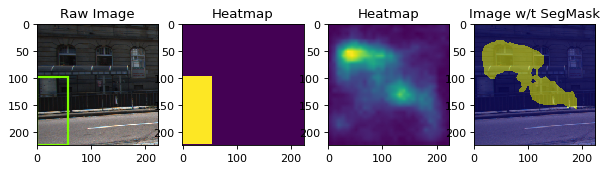

heat (2, 1000, 28, 28) 1.0 0.0


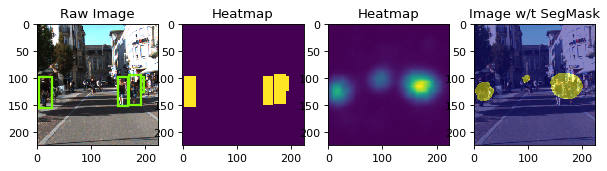

heat (2, 1000, 28, 28) 1.0 0.0


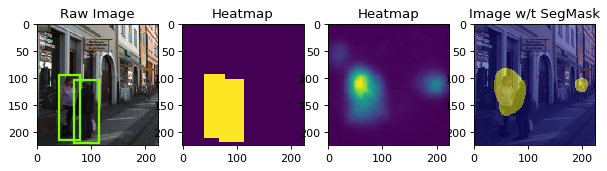

heat (2, 1000, 28, 28) 1.0 0.0


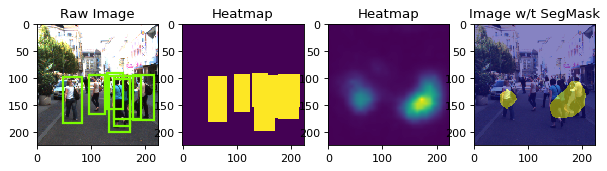

heat (2, 1000, 28, 28) 1.0 0.0


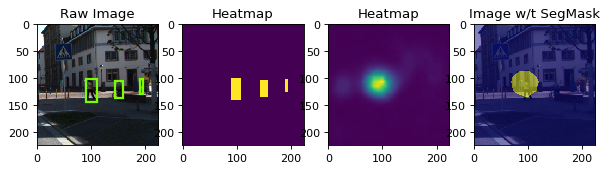

heat (2, 1000, 28, 28) 1.0 0.0


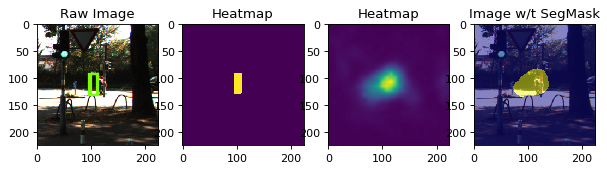

heat (2, 1000, 28, 28) 1.0 0.0


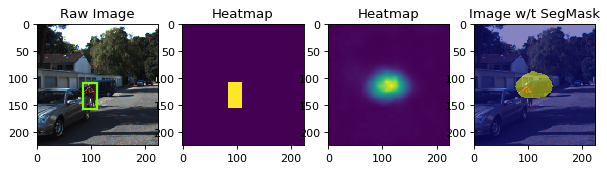

heat (2, 1000, 28, 28) 1.0 0.0


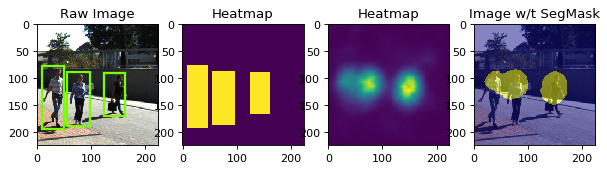

heat (2, 1000, 28, 28) 1.0 0.0


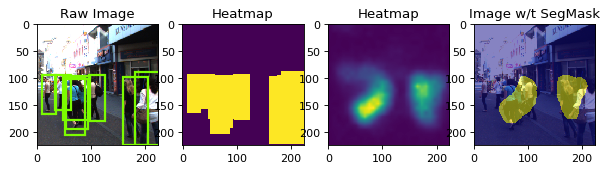

heat (2, 1000, 28, 28) 1.0 0.0


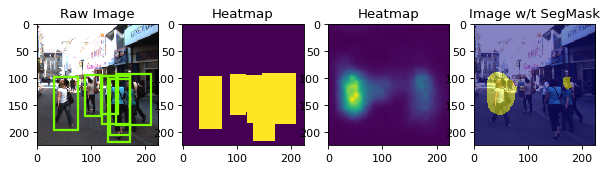

heat (2, 1000, 28, 28) 1.0 0.0


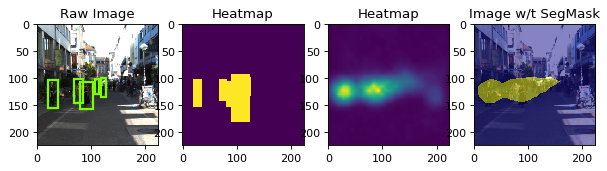

heat (2, 1000, 28, 28) 1.0 0.0


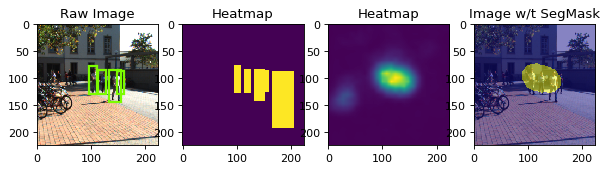

heat (2, 1000, 28, 28) 1.0 0.0


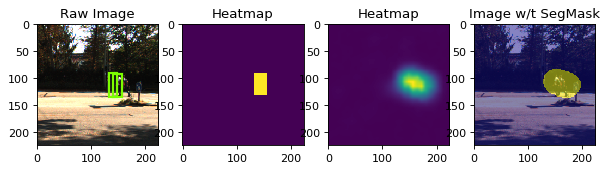

heat (2, 1000, 28, 28) 1.0 0.0


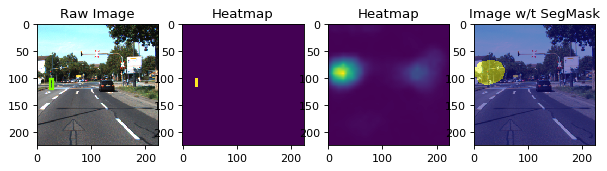

heat (2, 1000, 28, 28) 1.0 0.0


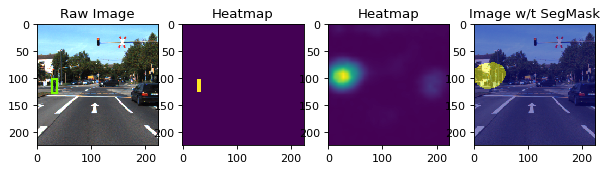

heat (2, 1000, 28, 28) 1.0 0.0


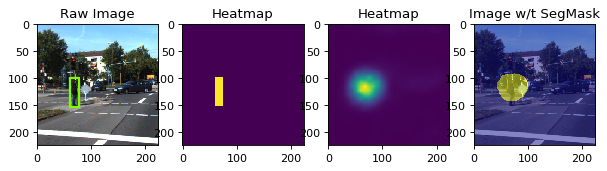

heat (2, 1000, 28, 28) 1.0 0.0


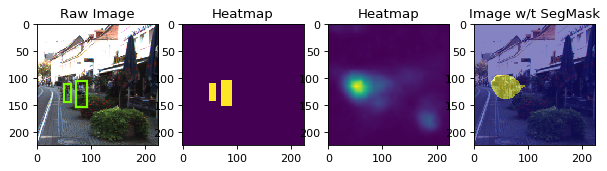

heat (2, 1000, 28, 28) 1.0 0.0


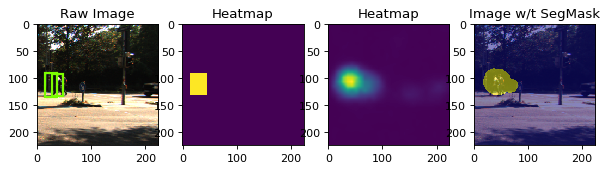

heat (2, 1000, 28, 28) 1.0 0.0


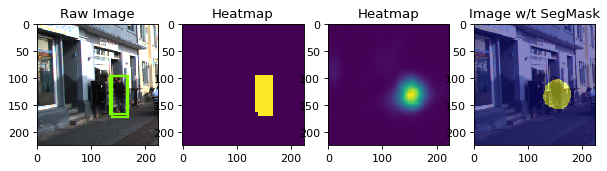

heat (2, 1000, 28, 28) 1.0 0.0


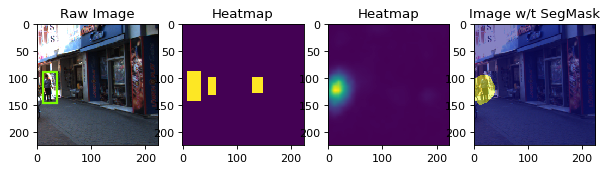

heat (2, 1000, 28, 28) 1.0 0.0


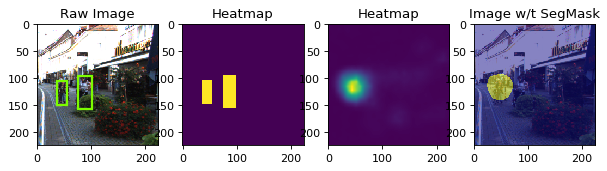

heat (2, 1000, 28, 28) 1.0 0.0


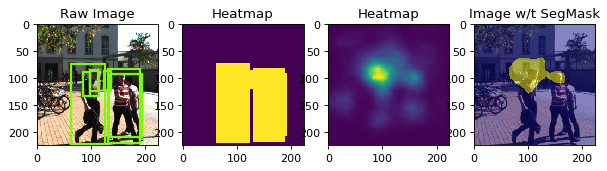

heat (2, 1000, 28, 28) 1.0 0.0


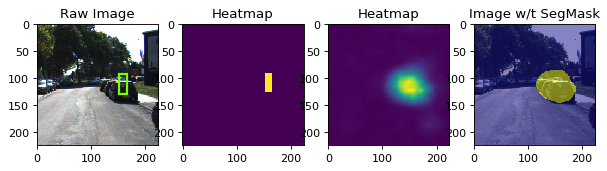

heat (2, 1000, 28, 28) 1.0 0.0


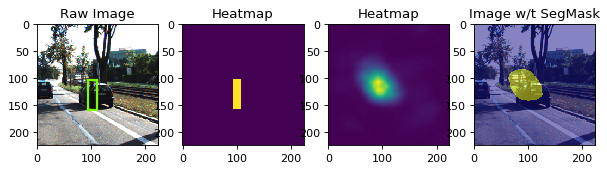

heat (2, 1000, 28, 28) 1.0 0.0


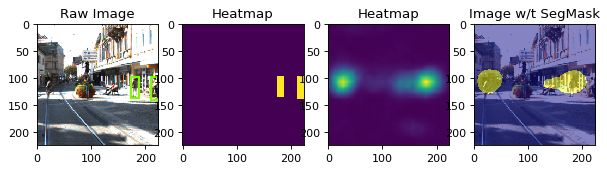

Testing Loss: 0.1137	Acc: 100.000


In [47]:
val(val_args)

In [31]:
def val_metric(args, model=None, current_epoch=0):
    top1 = AverageMeter()
    losses = AverageMeter()
    IOU_score = AverageMeter()
    top1.reset()
    losses.reset()
    IOU_score.reset()

    if model is None:
        model, _ = get_model(args)
    model.eval()
    _, val_loader = data_loader(args, test_path=True)

    save_atten = SAVE_ATTEN(save_dir='../save_bins/')

    global_counter = 0
    prob = None
    gt = None
    for idx, dat in enumerate(tqdm(val_loader)):
        img, target = dat
        if len(img) == 1: continue
        label = torch.FloatTensor([t["label"] for t in target])[:, None]

        global_counter += 1
        img, label = img.cuda(), label.cuda()
        img_var, label_var = Variable(img), Variable(label)
        logits = model(img_var, label_var)
        loss_val, _ = model.module.get_loss(logits, label_var)
        losses.update(loss_val.data, img.size()[0])

        logits0 = logits[0]
        logits0 = F.softmax(logits0, dim=1)
        prec1_1 = Metrics.accuracy(logits0.cpu().data, label_var.cpu().long(), topk=(1,))
        top1.update(prec1_1[0], img.size()[0])

        pred_cls_label = np.argmax(logits0[:, :2].cpu().data.numpy(), axis=1)
        #print("pred_cls", pred_cls_label)
        
        last_featmaps = model.module.get_localization_maps()
        np_last_featmaps = last_featmaps.cpu().data.numpy()

        for i in range(len(img)):
            if label[i] == 1 and pred_cls_label[i] == 1: # Only show TP cases

                # Calculate IOU
                target_mask = np.zeros((224, 224))
                #img_cpu = img[i].cpu().permute(1,2,0)
                for bbox in target[i]["bboxs"]:
                    target_mask[int(bbox.y1):int(bbox.y2), int(bbox.x1):int(bbox.x2)] = 1.0
                
                # attention mask
                np_last_featmaps_resize = cv2.resize(np_last_featmaps[i][1], (224, 224))
                seg_mask = (np_last_featmaps_resize >= 0.3).astype(np.float)
                iou_score = jaccard_similarity_score(seg_mask, target_mask)
                #print("IOU score:", iou_score)
                IOU_score.update(iou_score, 1)

    print("Testing Loss: %.4f\tAcc: %.3f\tIOU_score: %.3f" % (losses.avg, top1.avg, IOU_score.avg))

In [32]:
val_metric(val_args)

=> loading checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar'
=> loaded checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar' (epoch 9)
=> loaded checkpoint '../snapshots/inception_kitti_full_spg_exp2/kitti_epoch_9_glo_step_4430.pth.tar'




  0%|          | 0/253 [00:00<?, ?it/s]

Train size: 3540
Val size: 505
Test size: 1013




  0%|          | 1/253 [00:00<00:40,  6.29it/s]

  1%|          | 3/253 [00:00<00:32,  7.80it/s]

  2%|▏         | 6/253 [00:00<00:25,  9.69it/s]

  4%|▎         | 9/253 [00:00<00:21, 11.60it/s]

  5%|▍         | 12/253 [00:00<00:17, 13.61it/s]

  6%|▌         | 15/253 [00:00<00:15, 15.41it/s]

  7%|▋         | 18/253 [00:00<00:13, 16.98it/s]

  8%|▊         | 21/253 [00:01<00:12, 18.43it/s]

  9%|▉         | 24/253 [00:01<00:11, 19.61it/s]

 11%|█         | 27/253 [00:01<00:11, 20.37it/s]

 12%|█▏        | 30/253 [00:01<00:10, 21.14it/s]

 13%|█▎        | 33/253 [00:01<00:09, 22.04it/s]

 14%|█▍        | 36/253 [00:01<00:09, 22.36it/s]

 15%|█▌        | 39/253 [00:01<00:09, 22.82it/s]

 17%|█▋        | 42/253 [00:01<00:09, 22.54it/s]

 18%|█▊        | 45/253 [00:02<00:08, 23.13it/s]

100%|█████████▉| 252/253 [00:31<00:00, 22.02it/s]

 20%|██        | 51/253 [00:02<00:08, 22.73it/s]

 21%|██▏       | 54/253 [00:02<00:08, 22.59it/s]

 23%|██▎       | 57/253 [00:02<00:08, 22.94it/s]

 

Testing Loss: 0.1103	Acc: 99.603	IOU_score: 0.691
